In [11]:
import os

try:
    os.environ["PT_HPU_LAZY_MODE"] = "0"
    import habana_frameworks.torch.core as htcore 
    device_map = "hpu"
except ImportError:
    device_map = "auto"

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

from argparse import Namespace

import torch
import requests
import numpy as np

import cv2
from PIL import Image

import utils_model
import utils_gradio
import utils_attn


# Update rcParams to disable axes
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = False
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labelbottom'] = False
mpl.rcParams['ytick.left'] = False
mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.labelleft'] = False


In [24]:
# model_name_or_path = "microsoft/Phi-3.5-vision-instruct" 
model_name_or_path = "llava-hf/llava-1.5-7b-hf"

args = Namespace(
    model_name_or_path=model_name_or_path,
    load_4bit=False,
    load_8bit=False,
    device_map=device_map,
)
processor, model = utils_model.get_processor_model(args)

utils_gradio.processor = processor
utils_gradio.model = model

Some kwargs in processor config are unused and will not have any effect: num_additional_image_tokens. 
Loading checkpoint shards: 100%|██████████| 3/3 [00:04<00:00,  1.44s/steps]


In [28]:
prompt = "What is next to the cat?"
image_file = "http://images.cocodataset.org/val2017/000000039769.jpg"
raw_image = Image.open(requests.get(image_file, stream=True).raw)

image_process_mode = "Default"
state, _, _, _ = utils_gradio.add_text(None, prompt, raw_image, image_process_mode)

Building relevancy maps: 100%|██████████| 10/10 [00:11<00:00,  1.19s/steps]


ASSISTANT: A remote control is next to the cat.


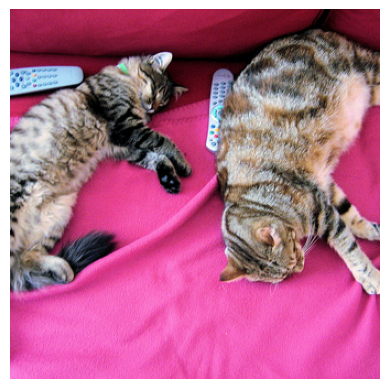

In [29]:
temperature = 0.2
top_p = 0.7
max_new_tokens = 16

state, _ = utils_gradio.lvlm_bot(state, temperature, top_p, max_new_tokens)

recovered_image = state.recovered_image
fig = plt.figure()
plt.imshow(recovered_image)
role, message = state.messages[-1]
print(f'{role}: {message}')

In [30]:

def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      colormap: int = cv2.COLORMAP_JET) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.
    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :returns: The default image with the cam overlay.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")

    cam = heatmap + img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

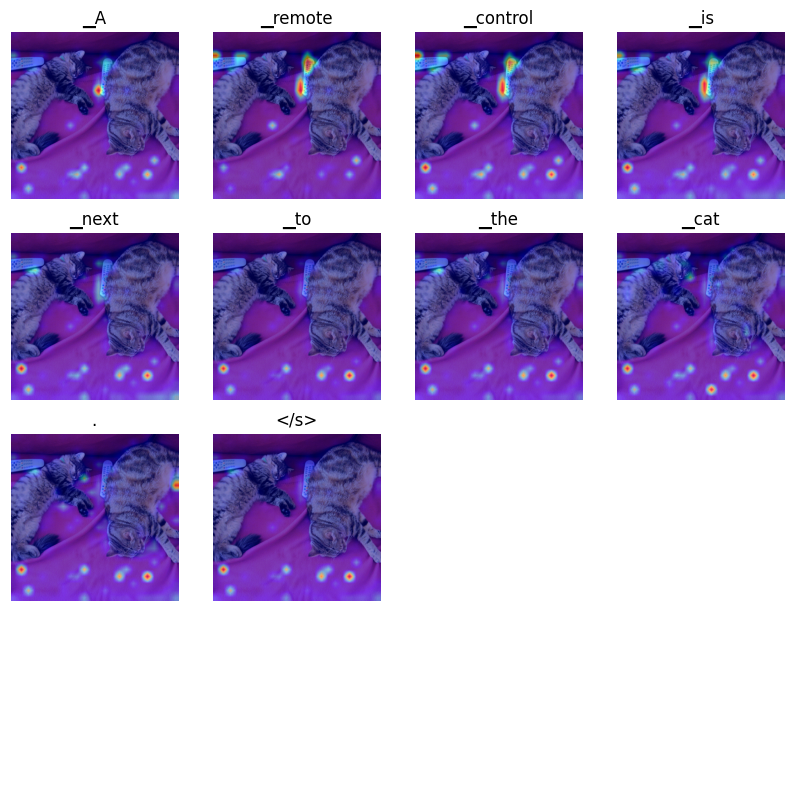

In [31]:
type_selector = 'llama'
fn_attention = state.attention_key + '_relevancy.pt'
recovered_image = state.recovered_image
img_idx = state.image_idx
word_rel_maps = torch.load(fn_attention)

word_rel_map = word_rel_maps[type_selector]
image_list = []


fig, axes = plt.subplots(4, 4, figsize=(10,10))
# fig.tight_layout()

for ax, (rel_key, rel_map) in zip(axes.ravel(), word_rel_map.items()):

    if (rel_map.shape[-1] != 577):
        rel_map = rel_map[-1,:][img_idx:img_idx+576].reshape(1,1,24,24).float()
    else:
        rel_map = rel_map[0,1:].reshape(1,1,24,24).float()
        
    rel_map_upscaled = torch.nn.functional.interpolate(rel_map, scale_factor=14, mode='bilinear')
    rel_map_upscaled = (rel_map_upscaled - rel_map_upscaled.min()) / (rel_map_upscaled.max() - rel_map_upscaled.min())
    rel_map_upscaled = rel_map_upscaled.squeeze(0).squeeze(0)
    
    original_image = np.array(recovered_image)
    original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())
    vis = show_cam_on_image(original_image, rel_map_upscaled.cpu().numpy())
    # vis = Image.from_array(vis)
    
    ax.imshow(vis)
    ax.set_title(f'{rel_key}')